Epoch 10/100, Loss: 0.2275
Epoch 20/100, Loss: 0.1904
Epoch 30/100, Loss: 0.1619
Epoch 40/100, Loss: 0.1417
Epoch 50/100, Loss: 0.1280
Epoch 60/100, Loss: 0.1186
Epoch 70/100, Loss: 0.1122
Epoch 80/100, Loss: 0.1075
Epoch 90/100, Loss: 0.1042
Epoch 100/100, Loss: 0.1017


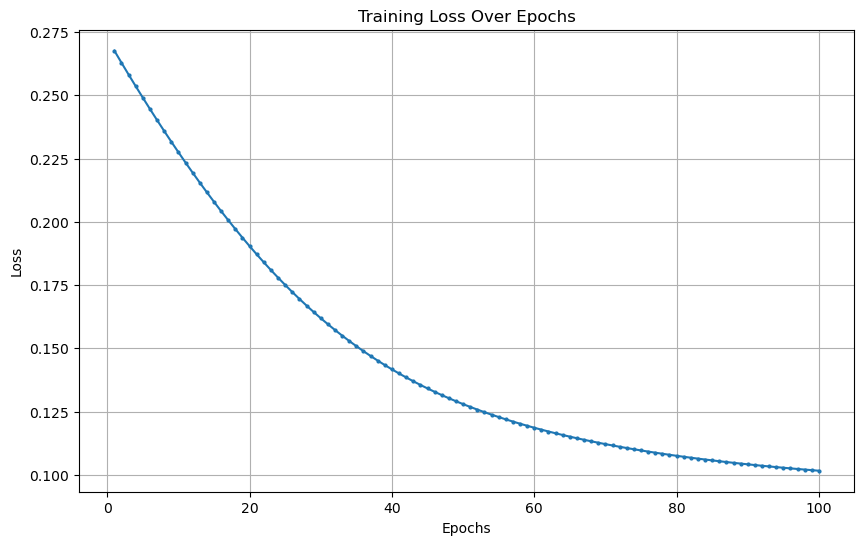

In [106]:
# Reference: Make Your Own Neural Network by Tariq Rashid (2016)

# Modified for study Purposes by John Boamah (January 11, 2025)
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, List, Optional

class NeuralNetwork:
    """
    Custom Neural Network implementation
    
    Args:
        input_layer (int): Number of input features
        hidden_layer (int): Number of neurons in hidden layer
        output_layer (int): Number of output classes
        learning_rate (float): Learning rate for weight updates
        seed (Optional[int]): Random seed for reproducibility
    """
    def __init__(self, input_layer: int, hidden_layer: int, output_layer: int, 
                 learning_rate: float, seed: Optional[int] = None):
        self.input_layer = input_layer
        self.hidden_layer = hidden_layer
        self.output_layer = output_layer
        self.learning_rate = learning_rate

        if seed is not None:
            np.random.seed(seed)

        # Initialization of weights using Glorot 
        self.w_input_hidden = np.random.normal(
            0, np.sqrt(2.0 / (input_layer + hidden_layer)),
            (hidden_layer, input_layer)
        )
        self.w_hidden_output = np.random.normal(
            0, np.sqrt(2.0 / (hidden_layer + output_layer)),
            (output_layer, hidden_layer)
        )

        # Activation functions
        self.activation = lambda x: 1 / (1 + np.exp(-x))
        # First derivative of the activation function
        self.activation_prime = lambda x: x * (1 - x)  

        # For MNIST datasets classification
        # def softmax(x):
        #     exp_x = np.exp(x - np.max(x, axis=0))
        #     return exp_x / np.sum(exp_x, axis=0)
        # self.softmax = softmax

    def forward(self, input_list: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """
        Forward pass through the network
        
        Args:
            input_list: Input features of shape (n_features,)
            
        Returns:
            Tuple containing:
                - Output layer activations
                - Hidden layer activations
        """
        try:
            inputs = np.array(input_list, ndmin=2).T
            if inputs.shape[0] != self.input_layer:
                raise ValueError(f"Expected {self.input_layer} inputs, got {inputs.shape[0]}")
        except Exception as e:
            raise ValueError(f"Invalid input format: {str(e)}")

        # Forward propagation
        hidden_inputs = np.dot(self.w_input_hidden, inputs)
        hidden_outputs = self.activation(hidden_inputs)
        final_inputs = np.dot(self.w_hidden_output, hidden_outputs)
        final_outputs = self.activation(final_inputs)
        # For MNIST dataset
        # final_outputs = self.softmax(final_inputs)

        return final_outputs, hidden_outputs

    def train(self, input_list: np.ndarray, target_list: np.ndarray) -> None:
        """
        Train the neural network using backpropagation
        
        Args:
            input_list: Input features
            target_list: Target values
        """
        try:
            inputs = np.array(input_list, ndmin=2).T
            targets = np.array(target_list, ndmin=2).T
            
            if targets.shape[0] != self.output_layer:
                raise ValueError(f"Expected {self.output_layer} targets, got {targets.shape[0]}")
        except Exception as e:
            raise ValueError(f"Invalid input/target format: {str(e)}")

        # Forward pass
        final_outputs, hidden_outputs = self.forward(input_list)

        # Backward pass
        # Output layer error
        output_errors = targets - final_outputs
        output_delta = output_errors * self.activation_prime(final_outputs)

        # Hidden layer error
        hidden_errors = np.dot(self.w_hidden_output.T, output_delta)
        hidden_delta = hidden_errors * self.activation_prime(hidden_outputs)
        

        # Update weights using gradient descent
        self.w_hidden_output += self.learning_rate * np.dot(output_delta, hidden_outputs.T)
        self.w_input_hidden += self.learning_rate * np.dot(hidden_delta, inputs.T)

    def calculate_loss(self, predictions: np.ndarray, targets: np.ndarray) -> float:
        """
        Calculate mean squared error loss
        
        Args:
            predictions: Network predictions
            targets: True target values
            
        Returns:
            float: MSE loss value
        """
        mse = np.mean((predictions - targets) ** 2)
        return mse

    # For classification problem (MNIST)
    # def calculate_loss(self, predictions: np.ndarray, targets: np.ndarray) -> float:
    #     """
    #     Calculate categorical cross-entropy loss
        
    #     Args:
    #         predictions: Network predictions (after softmax)
    #         targets: True target values (one-hot encoded)
            
    #     Returns:
    #         float: Cross-entropy loss value
    #     """
        
    #     epsilon = 1e-15 # Avoid log(0)
    #     predictions = np.clip(predictions, epsilon, 1 - epsilon)
        
    #     # Cross entropy loss
    #     cross_entropy = -np.sum(targets * np.log(predictions)) / predictions.shape[1]
    #     return cross_entropy

def train_network(data_path: str, input_n: int, hidden_n: int, output_n: int, 
                 lr: float, epochs: int, seed: Optional[int] = None) -> Tuple[NeuralNetwork, List[float]]:
    """
    Training loop
    Args:
        data_path: Path to the MNIST dataset
        input_n: Number of input features
        hidden_n: Number of hidden neurons
        output_n: Number of output classes
        lr: Learning rate
        epochs: Number of training epochs
        seed: Random seed
        
    Returns:
        Tuple containing:
            - Trained neural network
            - List of loss values per epoch
    """
    try:
        data = np.loadtxt(data_path, delimiter=",")
    except Exception as e:
        raise IOError(f"Failed to load dataset: {str(e)}")

    # Initialize network
    nn = NeuralNetwork(input_n, hidden_n, output_n, lr, seed)
    loss_values = []

    # Training loop
    for epoch in range(epochs):
        epoch_loss = 0
        for img in data:
            # Normalized inputs for [0.01, 1.0] range
            inputs = (img[1:] / 255.0 * 0.99) + 0.01
            
            # One-hot encoded targets
            targets = np.zeros(output_n) + 0.01
            targets[int(img[0])] = 0.99

            # Train and calculate loss
            nn.train(inputs, targets)
            predictions, _ = nn.forward(inputs)
            epoch_loss += nn.calculate_loss(predictions, targets)

        # Average loss for the epoch
        epoch_loss /= len(data)
        loss_values.append(epoch_loss)
        
        if (epoch + 1) % 10 == 0: 
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f}")

    return nn, loss_values

if __name__ == "__main__":
    INPUT_NEURONS = 784  # (28x28 pixels)
    HIDDEN_NEURONS = 100
    OUTPUT_NEURONS = 10  # 10 digits
    LEARNING_RATE = 0.001
    EPOCHS = 100
    
    try:
        nn, loss_history = train_network(
            "mnist_test_10.csv",
            INPUT_NEURONS,
            HIDDEN_NEURONS,
            OUTPUT_NEURONS,
            LEARNING_RATE,
            EPOCHS,
            seed=42
        )

        plt.figure(figsize=(10, 6))
        plt.plot(range(1, EPOCHS + 1), loss_history, marker='o', linestyle='-', markersize=2)
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title("Training Loss Over Epochs")
        plt.grid(True)
        plt.show()

    except Exception as e:
        print(f"Training failed: {str(e)}")

Epoch 10/100, Loss: 0.1025
Epoch 20/100, Loss: 0.0935
Epoch 30/100, Loss: 0.0925
Epoch 40/100, Loss: 0.0929
Epoch 50/100, Loss: 0.0939
Epoch 60/100, Loss: 0.0950
Epoch 70/100, Loss: 0.0963
Epoch 80/100, Loss: 0.0977
Epoch 90/100, Loss: 0.0991
Epoch 100/100, Loss: 0.1006

Accuracy: 100.00%


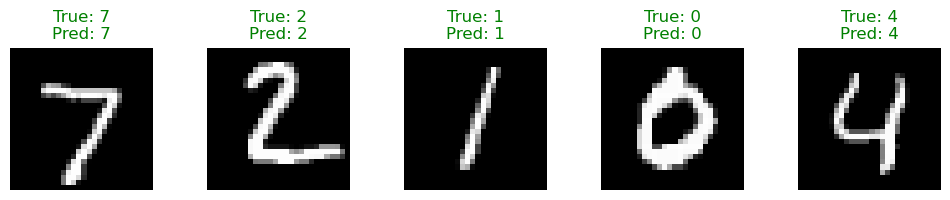

In [108]:
import numpy as np
import matplotlib.pyplot as plt

def test_neural_network(network, test_data_path):
    """
    Test the neural network and show results
    """
    test_data = np.loadtxt(test_data_path, delimiter=",")
    
    correct_predictions = 0
    total_samples = len(test_data)
    

    for data in test_data:
        correct_label = int(data[0]) # True label
        inputs = (data[1:] / 255.0 * 0.99) + 0.01
        
        outputs, _ = network.forward(inputs)
        predicted_label = np.argmax(outputs)  # highest probability prediction

        if predicted_label == correct_label:
            correct_predictions += 1
    
    accuracy = correct_predictions / total_samples
    print(f"\nAccuracy: {accuracy:.2%}")
    
    image_predictions(network, test_data, num_examples=5)

def image_predictions(network, test_data, num_examples=5):
    """
    Images and their predictions
    """
    plt.figure(figsize=(2*num_examples, 2))
    
    for i in range(num_examples):
       
        image_data = test_data[i]
        true_label = int(image_data[0])
        
        inputs = (image_data[1:] / 255.0 * 0.99) + 0.01
        outputs, _ = network.forward(inputs)
        predicted_label = np.argmax(outputs)
        
        plt.subplot(1, num_examples, i + 1)
        plt.imshow(image_data[1:].reshape(28, 28), cmap='gray')
        plt.axis('off')
    
        color = 'green' if predicted_label == true_label else 'red'
        plt.title(f'True: {true_label}\nPred: {predicted_label}', color=color)
    
    plt.tight_layout()
    plt.show()

# Test network

test_data_path = "mnist_test_10.csv"
INPUT_NEURONS = 784  # (28x28 pixels)
HIDDEN_NEURONS = 100
OUTPUT_NEURONS = 10  # 10 digits
LEARNING_RATE = 0.01
EPOCHS = 100
    
NN, loss_history = train_network(
            "mnist_test_10.csv",
            INPUT_NEURONS,
            HIDDEN_NEURONS,
            OUTPUT_NEURONS,
            LEARNING_RATE,
            EPOCHS,
            # seed=42
        )
test_neural_network(NN, test_data_path)